In [1]:
# Standard Library Imports (if any)

# Third-party Library Imports
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects
from adjustText import adjust_text

# Local Module Imports
from utils import *
from new_data_handling import DataManager
from plot import *
from new_data_handling.data_processor import *

In [2]:
major = COUNTRIES.MAJOR
offshore = COUNTRIES.OFFSHORE
sample = major + offshore
period = (2001, 2004)
save = None
interpolate = False
dm = DataManager(
    raw_dir = "../data/raw",
    save_dir = "../data/clean"
)
ds_full = dm.get_dataset("ds")
fed_full = dm.get_dataset("fed")
# dm.clean_data()
# dm.save_data()

In [22]:
# Index returns
period = (2001, 2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
panel_dates = fed.columns
returns_index = compute_index_excess_returns(ds, fed, major)

riskfree = annual_to_monthly_return(fed.iloc[0]).mean()
codes = list(returns_index.index)

# Weights
period = (2001, 2004)
cpis = dm.cpis.get_data(period=period)
wb = dm.wb.get_data(countries=major, period=period)
weights_per_year = compute_weights(cpis, wb, major, offshore)
weights = weights_per_year.mean(axis=1).unstack(level="Country")
weights["MX"] = weights_per_year.loc["MX"][[2003,2004]].mean(axis=1)

# Data
drop = []
y = returns_index.mean(axis=1).drop(labels=drop)
x1 = returns_index.var(axis=1).drop(labels=drop)
x2 = x1 @ weights.drop(columns=drop, index=drop)
codes = list(y.index)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.009
Date:                Wed, 14 May 2025   Prob (F-statistic):             0.0913
Time:                        23:15:31   Log-Likelihood:                 124.72
No. Observations:                  38   AIC:                            -245.4
Df Residuals:                      36   BIC:                            -242.2
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0092      0.002      5.225      0.0

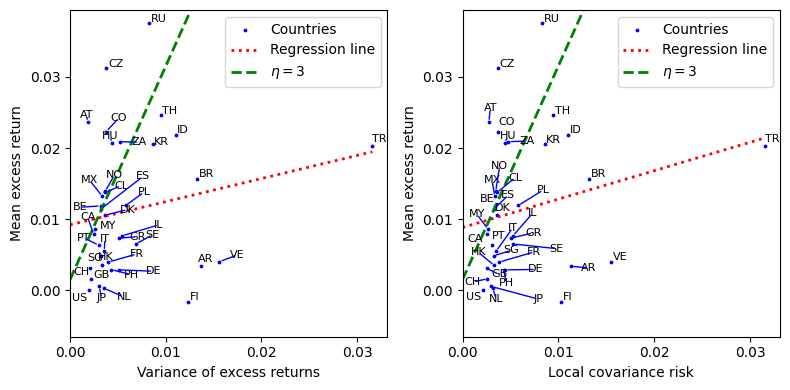

In [23]:
X = sm.add_constant(x1)
model = sm.OLS(y, X).fit(cov_type="HC0")
print(model.summary())
y_pred = model.predict(X)
x_max = x1.max()
y_max = y_pred.iloc[x1.argmax()]
fig, axs = plt.subplots(1, 2, figsize=(8, 4)) 
axs[0].scatter(x1, y, color='blue', s=3, label="Countries")
axs[0].plot([0, x_max], [model.params["const"], y_max], color='red', linewidth=2, linestyle="dotted", label='Regression line')
axs[0].plot([0, x_max], [riskfree, riskfree + 3 * x_max], color='green', linewidth=2, linestyle="dashed", label=r'$\eta = 3$')
axs[0].set_ylim(top=y.max() * 1.05)
axs[0].set_xlim(left=0)
axs[0].set_xlabel("Variance of excess returns")
axs[0].set_ylabel("Mean excess return")
ticks = [0,0.01,0.02,0.03]
axs[0].set_xticks(ticks)
axs[0].set_yticks(ticks)
axs[0].legend()
texts = []
for i, code in enumerate(codes):
    text = axs[0].text(x1.iloc[i], y.iloc[i], code, fontsize=8)
    texts.append(text)
adjust_text(texts, ax=axs[0], force_text=0.5, force_objects=0.5, arrowprops=dict(arrowstyle="-", color='blue'))

X = sm.add_constant(x2)
model = sm.OLS(y, X).fit(cov_type="HC0")
print(model.summary())
y_pred = model.predict(X)
x_max = x2.max()
y_max = y_pred.iloc[x2.argmax()]
axs[1].scatter(x2, y, color='blue', s=3, label="Countries")
axs[1].plot([0, x_max], [model.params["const"], y_max], color='red', linewidth=2, linestyle="dotted", label='Regression line')
axs[1].plot([0, x_max], [riskfree, riskfree + 3 * x_max], color='green', linewidth=2, linestyle="dashed", label=r'$\eta = 3$')
axs[1].set_ylim(top=y.max() * 1.05)
axs[1].set_xlim(left=0)
axs[1].set_xlabel("Local covariance risk")
axs[1].set_ylabel("Mean excess return")
axs[1].set_xticks(ticks)
axs[1].set_yticks(ticks)
axs[1].legend()
texts = []
for i, code in enumerate(codes):
    text = axs[1].text(x2.iloc[i], y.iloc[i], code, fontsize=8)
    texts.append(text)
adjust_text(texts, ax=axs[1], force_text=0.5, force_objects=0.5, arrowprops=dict(arrowstyle="-", color='blue'))
plt.tight_layout()
dir = os.path.abspath("../output/exp1/figures/")
fig.savefig(dir+"/fig1.pdf")
plt.show()
copy_files()

In [ ]:
# DEFENSE
X = sm.add_constant(x1)
model = sm.OLS(y, X).fit(cov_type="HC0")
print(model.summary())
y_pred = model.predict(X)
x_max = x1.max()
y_max = y_pred.iloc[x1.argmax()]
fig, axs = plt.subplots(1, 2, figsize=(6, 4)) 
axs[0].scatter(x1, y, color='blue', s=3, label="Countries")
axs[0].plot([0, x_max], [model.params["const"], y_max], color='red', linewidth=2, linestyle="dotted", label='Regression line')
axs[0].plot([0, x_max], [riskfree, riskfree + 3 * x_max], color='green', linewidth=2, linestyle="dashed", label=r'$\eta f = 3$')
axs[0].set_ylim(top=y.max() * 1.05)
axs[0].set_xlim(left=0)
axs[0].set_xlabel("Variance of excess returns")
axs[0].set_ylabel("Mean excess return")
ticks = [0,0.01,0.02,0.03]
axs[0].set_xticks(ticks)
axs[0].set_yticks(ticks)
# axs[0].legend()
# texts = []
# for i, code in enumerate(codes):
#     text = axs[0].text(x1.iloc[i], y.iloc[i], code, fontsize=6)
#     texts.append(text)
# adjust_text(texts, ax=axs[0], force_text=0.5, force_objects=0.5, arrowprops=dict(arrowstyle="-", color='blue'))
fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0))

X = sm.add_constant(x2)
model = sm.OLS(y, X).fit(cov_type="HC0")
print(model.summary())
y_pred = model.predict(X)
x_max = x2.max()
y_max = y_pred.iloc[x2.argmax()]
axs[1].scatter(x2, y, color='blue', s=3, label="Countries")
axs[1].plot([0, x_max], [model.params["const"], y_max], color='red', linewidth=2, linestyle="dotted", label='Regression line')
axs[1].plot([0, x_max], [riskfree, riskfree + 3 * x_max], color='green', linewidth=2, linestyle="dashed", label=r'$\eta f = 3$')
axs[1].set_ylim(top=y.max() * 1.05)
axs[1].set_xlim(left=0)
axs[1].set_xlabel("Local covariance risk")
axs[1].set_ylabel("Mean excess return")
axs[1].set_xticks(ticks)
axs[1].set_yticks(ticks)
# axs[1].legend()
# texts = []
# for i, code in enumerate(codes):
#     text = axs[1].text(x2.iloc[i], y.iloc[i], code, fontsize=6)
#     texts.append(text)
# adjust_text(texts, ax=axs[1], force_text=0.5, force_objects=0.5, arrowprops=dict(arrowstyle="-", color='blue'))
plt.tight_layout()
dir = os.path.abspath("../output/exp1/figures/")
fig.savefig(dir+"/fig1.png", bbox_inches="tight", transparent=True)
plt.show()
copy_files()

In [ ]:
period = (2011, 2014)
cpis = dm.cpis.get_data(period=period)
wb = dm.wb.get_data(countries=major, period=period)
weights_per_year = compute_weights(cpis, wb, major, offshore)
weights = weights_per_year.mean(axis=1).unstack(level="Country")